## 1. Getting all Biopython data for your sequences

We still need to generate and save all the data for the Biopython predictions, that is done in code below. We are doing the same as in the previous Jupyter page, but are now looping over all sequences, keeping track of that information, and saving it in a JSON file.

In [1]:
import json

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from utils import extractFastaInfo, extractClustalInfo

# Here set the format of your input file as a string (fasta or clustal)
# and define the name of your multiple sequence alignment (MSA) file.
# Note that this MSA file has to be in the same directory as this Jupyter file
fileFormat = 'fasta'
msaFilePath = "final_msa.fasta"

# Extract the information
if fileFormat == 'fasta':
    (seqAlignInfo,seqIds) = extractFastaInfo(msaFilePath)
elif fileFormat == 'clustal':
    (seqAlignInfo,seqIds) = extractClustalInfo(msaFilePath)
else:
    print("No valid file format given.")


# Now we are going to calculate all the biopython features for all sequences, and save the result in a JSON file
# that we can later load again
seqsDict = {}
for seqId in seqAlignInfo.keys():
    # Here we take out all the gaps '-' from the sequences, otherwise they won't be predicted correctly!
    seqsDict[seqId] = seqAlignInfo[seqId].replace("-","")

# This is a python list with all the Uniprot IDs of the sequences in the MSA
seqIds = list(seqsDict.keys())

# This is a python dictionary that we will use to store all biopython calculated information.
# We here already set up all the labels (keys in python terminology) to store the different types of data
biopythonInformation = {
    
    'aminoAcidNumbers': {},
    'aminoAcidFractions': {},
    'molecularWeights': {},
    'aromaticity': {},
    'instability': {},
    'isoelectricPoint': {},
    'flexibility': {},
    'helixFraction': {},
    'sheetFraction': {},
    'coilFraction': {}

}

# Here 'looping' over all the sequences and calculating the relevant information
for seqId in seqIds:
    
    # See last Jupyter page, this is Biopython code
    x = ProteinAnalysis(seqsDict[seqId])
    secStruc = x.secondary_structure_fraction()
    
    # Here there will be twenty values, one per amino acid type
    biopythonInformation['aminoAcidNumbers'][seqId] = x.count_amino_acids()
    biopythonInformation['aminoAcidFractions'][seqId] = x.get_amino_acids_percent()
    
    # These are per-protein values, so only one per protein
    biopythonInformation['molecularWeights'][seqId] = x.molecular_weight()
    biopythonInformation['aromaticity'][seqId] = x.aromaticity()
    biopythonInformation['instability'][seqId] = x.instability_index()
    biopythonInformation['isoelectricPoint'][seqId] = x.isoelectric_point()
    
    # Here we access the secondary structure fraction information from the secStruc
    # list, so [0] is the first element, [1] the second, ...
    biopythonInformation['helixFraction'][seqId] = secStruc[0]
    biopythonInformation['sheetFraction'][seqId] = secStruc[1]
    biopythonInformation['coilFraction'][seqId] = secStruc[2]

    # The flexibility are per-residue values, so one per amino acid in the sequence.
    # This calculates 9 values less than there actually are in the sequence, so cannot be 
    # directly connected to the dynaMine data. The first five and last four residues are missing.
    biopythonInformation['flexibility'][seqId] = x.flexibility()
    
print(biopythonInformation)

# The info will be stored in this file
outFile = 'biopython.json'
with open(outFile, 'w+') as outfile:
        json.dump(biopythonInformation, outfile, indent=4)
        

{'aminoAcidNumbers': {'P02144': {'A': 12, 'C': 1, 'D': 8, 'E': 14, 'F': 7, 'G': 15, 'H': 9, 'I': 8, 'K': 20, 'L': 17, 'M': 4, 'N': 3, 'P': 5, 'Q': 7, 'R': 2, 'S': 7, 'T': 4, 'V': 7, 'W': 2, 'Y': 2}, 'P02166': {'A': 15, 'C': 0, 'D': 8, 'E': 13, 'F': 7, 'G': 14, 'H': 9, 'I': 9, 'K': 19, 'L': 17, 'M': 3, 'N': 4, 'P': 5, 'Q': 6, 'R': 2, 'S': 6, 'T': 6, 'V': 7, 'W': 2, 'Y': 2}, 'P02150': {'A': 12, 'C': 0, 'D': 8, 'E': 14, 'F': 6, 'G': 14, 'H': 9, 'I': 8, 'K': 20, 'L': 18, 'M': 4, 'N': 3, 'P': 5, 'Q': 7, 'R': 2, 'S': 8, 'T': 4, 'V': 8, 'W': 2, 'Y': 2}, 'P02165': {'A': 15, 'C': 0, 'D': 8, 'E': 14, 'F': 7, 'G': 14, 'H': 8, 'I': 8, 'K': 20, 'L': 17, 'M': 3, 'N': 3, 'P': 4, 'Q': 8, 'R': 2, 'S': 7, 'T': 4, 'V': 8, 'W': 2, 'Y': 2}, 'P02189': {'A': 14, 'C': 0, 'D': 8, 'E': 14, 'F': 7, 'G': 15, 'H': 9, 'I': 6, 'K': 19, 'L': 18, 'M': 4, 'N': 3, 'P': 4, 'Q': 7, 'R': 2, 'S': 7, 'T': 5, 'V': 8, 'W': 2, 'Y': 2}, 'P68084': {'A': 13, 'C': 0, 'D': 8, 'E': 14, 'F': 6, 'G': 14, 'H': 9, 'I': 8, 'K': 20, 'L': 1

## 2. Calculating pairwise sequence distances

Here we generate the distances between the sequences based a pairwise alignment. You can change gap penalties, as well as the scoring matrix, in below if you want to change the settings.


In [2]:
from Bio import Align
from Bio.Align import substitution_matrices

# Set up the alignment procedure. You can modify the parameters, up to you how to calculate the distances between
# sequences
aligner = Align.PairwiseAligner()
aligner.open_gap_score=-6
aligner.extend_gap_score=-2
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62") # Other default matrices are available as well
aligner.mode = 'global' # Can be 'local', 'global'

#
# Here you can define a subregion of the MSA to calculate the pairwise score for. If you do, then 
# also don't forget to change the output filename - you can save multiple results in multiple files this
# way (for example for different regions) and analyse them separately
#

outFile = 'seqDistances_1.json'

# Here define your region, counted in columns in the MSA. Remember that Python starts counting at zero, so
# the first position is 0!
regionStartInMsa = 0
regionEndInMsa = len(seqAlignInfo[seqIds[0]]) # This is the full length of the MSA

seqsDictForDistances = {}
for seqId in seqAlignInfo.keys():
    # Here we take out all the gaps '-' from the sequences, otherwise they won't be predicted correctly!
    seqsDictForDistances[seqId] = seqAlignInfo[seqId][regionStartInMsa:regionEndInMsa].replace("-","")

# We now have to calculate all the pairwise scores between sequences, so we are comparing all sequences to all other
# sequences. Try some print() statements in there to see what's going on if you want to understand the code

sequenceDistances = {}
lowestValue = 999999
for firstSeqIndex in range(len(seqIds)-1):
    firstSeqId = seqIds[firstSeqIndex]
    firstSeqId_matrix = firstSeqId.replace(' ','').replace("-","_")
    
    if firstSeqId_matrix not in sequenceDistances.keys():
        sequenceDistances[firstSeqId_matrix] = {}
        
    for secondSeqIndex in range(firstSeqIndex+1,len(seqIds)):
        secondSeqId = seqIds[secondSeqIndex]
        secondSeqId_matrix = secondSeqId.replace(" ","").replace("-","_")
        
        alignments = aligner.align(seqsDictForDistances[firstSeqId], seqsDictForDistances[secondSeqId])
        
        alignmentScore = alignments[0].score
        
        if lowestValue > alignmentScore:
            lowestValue = alignmentScore
        
        # Keeping track of both combinations, might not be necessary
        sequenceDistances[firstSeqId_matrix][secondSeqId_matrix] = alignmentScore
        
        if secondSeqId_matrix not in sequenceDistances.keys():
            sequenceDistances[secondSeqId_matrix] = {}
        sequenceDistances[secondSeqId_matrix][firstSeqId_matrix] = alignmentScore

        print(firstSeqId, firstSeqId_matrix, secondSeqId, secondSeqId_matrix, alignmentScore)
        #print(alignment[0])

#
# Rescale matrix if lowest value is negative
#

if lowestValue < 0:
    for seqId1 in sequenceDistances.keys():
        for seqId2 in sequenceDistances[seqId1].keys():
            sequenceDistances[seqId1][seqId2] -= lowestValue
        
# 
# For the SPSS analysis, you can use the distance matrix directly using the procedure described here:
#   https://www.ibm.com/support/pages/cluster-distance-matrix-input
#

with open(outFile, 'w+') as outfile:
        json.dump(sequenceDistances, outfile, indent=4)



P02144 P02144 P02166 P02166 728.0
P02144 P02144 P02150 P02150 769.0
P02144 P02144 P02165 P02165 741.0
P02144 P02144 P02189 P02189 758.0
P02144 P02144 P68084 P68084 773.0
P02144 P02144 P68086 P68086 773.0
P02144 P02144 P68085 P68085 773.0
P02144 P02144 P02147 P02147 801.0
P02144 P02144 P20856 P20856 731.0
P02144 P02144 P02145 P02145 804.0
P02144 P02144 A0A024R1G3 A0A024R1G3 781.0
P02144 P02144 A0A1K0FU49 A0A1K0FU49 809.0
P02144 P02144 F2Z2F1 F2Z2F1 460.0
P02144 P02144 A0A2J8QPD0 A0A2J8QPD0 460.0
P02144 P02144 B0QYF8 B0QYF8 725.0
P02144 P02144 A0A2K6NL17 A0A2K6NL17 769.0
P02144 P02144 R9RZM3 R9RZM3 753.0
P02144 P02144 A0A3Q7VSZ0 A0A3Q7VSZ0 753.0
P02144 P02144 A0A6P3EQL6 A0A6P3EQL6 731.0
P02144 P02144 A0A6I9IAX0 A0A6I9IAX0 740.0
P02144 P02144 F6PMG4 F6PMG4 742.0
P02144 P02144 A0A250XVB6 A0A250XVB6 739.0
P02144 P02144 A0A1K0GGA6 A0A1K0GGA6 769.0
P02144 P02144 G7N3Q2 G7N3Q2 769.0
P02144 P02144 G7PFA9 G7PFA9 769.0
P02144 P02144 A0A2K6DJM1 A0A2K6DJM1 769.0
P02144 P02144 R9S070 R9S070 722.0
P0

P02189 P02189 A0A6G1B1B0 A0A6G1B1B0 766.0
P02189 P02189 A0A091D6D3 A0A091D6D3 751.0
P02189 P02189 A0A663D630 A0A663D630 753.0
P02189 P02189 A0A2J8QPC5 A0A2J8QPC5 753.0
P02189 P02189 A0A2R9BL13 A0A2R9BL13 753.0
P02189 P02189 A0A2J8QPC2 A0A2J8QPC2 678.0
P02189 P02189 A0A2J8QPD7 A0A2J8QPD7 187.0
P02189 P02189 A0A2J8QPB9 A0A2J8QPB9 350.0
P02189 P02189 UPI000C2AAD7E UPI000C2AAD7E 680.0
P02189 P02189 UPI000C29E88A UPI000C29E88A 760.0
P02189 P02189 UPI00136447F5 UPI00136447F5 724.0
P02189 P02189 UPI000CEFDAE9 UPI000CEFDAE9 725.0
P68084 P68084 P68086 P68086 800.0
P68084 P68084 P68085 P68085 800.0
P68084 P68084 P02147 P02147 765.0
P68084 P68084 P20856 P20856 734.0
P68084 P68084 P02145 P02145 768.0
P68084 P68084 A0A024R1G3 A0A024R1G3 745.0
P68084 P68084 A0A1K0FU49 A0A1K0FU49 773.0
P68084 P68084 F2Z2F1 F2Z2F1 454.0
P68084 P68084 A0A2J8QPD0 A0A2J8QPD0 454.0
P68084 P68084 B0QYF8 B0QYF8 698.0
P68084 P68084 A0A2K6NL17 A0A2K6NL17 796.0
P68084 P68084 R9RZM3 R9RZM3 756.0
P68084 P68084 A0A3Q7VSZ0 A0A3Q7V

P20856 P20856 UPI000C2AAD7E UPI000C2AAD7E 653.0
P20856 P20856 UPI000C29E88A UPI000C29E88A 733.0
P20856 P20856 UPI00136447F5 UPI00136447F5 697.0
P20856 P20856 UPI000CEFDAE9 UPI000CEFDAE9 698.0
P02145 P02145 A0A024R1G3 A0A024R1G3 776.0
P02145 P02145 A0A1K0FU49 A0A1K0FU49 804.0
P02145 P02145 F2Z2F1 F2Z2F1 460.0
P02145 P02145 A0A2J8QPD0 A0A2J8QPD0 460.0
P02145 P02145 B0QYF8 B0QYF8 720.0
P02145 P02145 A0A2K6NL17 A0A2K6NL17 764.0
P02145 P02145 R9RZM3 R9RZM3 748.0
P02145 P02145 A0A3Q7VSZ0 A0A3Q7VSZ0 748.0
P02145 P02145 A0A6P3EQL6 A0A6P3EQL6 726.0
P02145 P02145 A0A6I9IAX0 A0A6I9IAX0 735.0
P02145 P02145 F6PMG4 F6PMG4 737.0
P02145 P02145 A0A250XVB6 A0A250XVB6 734.0
P02145 P02145 A0A1K0GGA6 A0A1K0GGA6 764.0
P02145 P02145 G7N3Q2 G7N3Q2 764.0
P02145 P02145 G7PFA9 G7PFA9 764.0
P02145 P02145 A0A2K6DJM1 A0A2K6DJM1 764.0
P02145 P02145 R9S070 R9S070 717.0
P02145 P02145 R9RZA9 R9RZA9 -104.0
P02145 P02145 A0A2T4CW89 A0A2T4CW89 521.0
P02145 P02145 A0A2K5NML8 A0A2K5NML8 768.0
P02145 P02145 A0A0D9R744 A0A0D9

F6PMG4 F6PMG4 R9RZ90 R9RZ90 710.0
F6PMG4 F6PMG4 A0A6G1B1B0 A0A6G1B1B0 730.0
F6PMG4 F6PMG4 A0A091D6D3 A0A091D6D3 713.0
F6PMG4 F6PMG4 A0A663D630 A0A663D630 737.0
F6PMG4 F6PMG4 A0A2J8QPC5 A0A2J8QPC5 737.0
F6PMG4 F6PMG4 A0A2R9BL13 A0A2R9BL13 737.0
F6PMG4 F6PMG4 A0A2J8QPC2 A0A2J8QPC2 662.0
F6PMG4 F6PMG4 A0A2J8QPD7 A0A2J8QPD7 175.0
F6PMG4 F6PMG4 A0A2J8QPB9 A0A2J8QPB9 337.0
F6PMG4 F6PMG4 UPI000C2AAD7E UPI000C2AAD7E 674.0
F6PMG4 F6PMG4 UPI000C29E88A UPI000C29E88A 754.0
F6PMG4 F6PMG4 UPI00136447F5 UPI00136447F5 718.0
F6PMG4 F6PMG4 UPI000CEFDAE9 UPI000CEFDAE9 719.0
A0A250XVB6 A0A250XVB6 A0A1K0GGA6 A0A1K0GGA6 742.0
A0A250XVB6 A0A250XVB6 G7N3Q2 G7N3Q2 742.0
A0A250XVB6 A0A250XVB6 G7PFA9 G7PFA9 742.0
A0A250XVB6 A0A250XVB6 A0A2K6DJM1 A0A2K6DJM1 742.0
A0A250XVB6 A0A250XVB6 R9S070 R9S070 723.0
A0A250XVB6 A0A250XVB6 R9RZA9 R9RZA9 -105.0
A0A250XVB6 A0A250XVB6 A0A2T4CW89 A0A2T4CW89 520.0
A0A250XVB6 A0A250XVB6 A0A2K5NML8 A0A2K5NML8 738.0
A0A250XVB6 A0A250XVB6 A0A0D9R744 A0A0D9R744 738.0
A0A250XVB6 A0A250XV

A0A6G1B1B0 A0A6G1B1B0 UPI000C2AAD7E UPI000C2AAD7E 663.0
A0A6G1B1B0 A0A6G1B1B0 UPI000C29E88A UPI000C29E88A 743.0
A0A6G1B1B0 A0A6G1B1B0 UPI00136447F5 UPI00136447F5 707.0
A0A6G1B1B0 A0A6G1B1B0 UPI000CEFDAE9 UPI000CEFDAE9 708.0
A0A091D6D3 A0A091D6D3 A0A663D630 A0A663D630 726.0
A0A091D6D3 A0A091D6D3 A0A2J8QPC5 A0A2J8QPC5 726.0
A0A091D6D3 A0A091D6D3 A0A2R9BL13 A0A2R9BL13 726.0
A0A091D6D3 A0A091D6D3 A0A2J8QPC2 A0A2J8QPC2 651.0
A0A091D6D3 A0A091D6D3 A0A2J8QPD7 A0A2J8QPD7 168.0
A0A091D6D3 A0A091D6D3 A0A2J8QPB9 A0A2J8QPB9 327.0
A0A091D6D3 A0A091D6D3 UPI000C2AAD7E UPI000C2AAD7E 648.0
A0A091D6D3 A0A091D6D3 UPI000C29E88A UPI000C29E88A 728.0
A0A091D6D3 A0A091D6D3 UPI00136447F5 UPI00136447F5 697.0
A0A091D6D3 A0A091D6D3 UPI000CEFDAE9 UPI000CEFDAE9 698.0
A0A663D630 A0A663D630 A0A2J8QPC5 A0A2J8QPC5 812.0
A0A663D630 A0A663D630 A0A2R9BL13 A0A2R9BL13 812.0
A0A663D630 A0A663D630 A0A2J8QPC2 A0A2J8QPC2 728.0
A0A663D630 A0A663D630 A0A2J8QPD7 A0A2J8QPD7 218.0
A0A663D630 A0A663D630 A0A2J8QPB9 A0A2J8QPB9 400.0
A0

## 3. Connecting data from different files

The key here is to use the unique Uniprot identifiers to connect information from the files, below we do this to combine all data into a single dataframe

In [3]:
import json
import pandas as pd

# Load in the data files we generated - note that you can always update these by running
# one of the previous cells. Make sure you keep a copy of the original though, just in case
# things go wrong

#
# The csv file from uniprot
#
fileName = "proteins.tab"
proteinData = pd.read_csv(fileName, sep="\t").set_index("Entry").sort_index()

#
# The predictions from DynaMine, ...
#
dynaminePredFile = 'predictions.json'
file = open(dynaminePredFile, 'r')
input = file.read()
dynamineRawData = json.loads(input)

# Reorganising this data bit to make it easier to use, also removing None values (can be present)
dynaMineData = {}
dynaMineValueTypes = ['disoMine', 'backbone', 'sidechain', 'earlyFolding']
for dynaMineValueType in dynaMineValueTypes:
    dynaMineData[dynaMineValueType] = {}
    
for resultDict in dynamineRawData['results']:
    proteinID = resultDict['proteinID']
    removeNonePositions = []
    for dynaMineValueType in dynaMineValueTypes:
        dynaMineData[dynaMineValueType][proteinID] = resultDict[dynaMineValueType]
        
        for i in range(len(resultDict[dynaMineValueType])):
            if resultDict[dynaMineValueType][i] == None:
                if i not in removeNonePositions:
                    removeNonePositions.append(i)
    
    removeNonePositions.reverse()
    for i in removeNonePositions:
        for dynaMineValueType in dynaMineValueTypes:
            dynaMineData[dynaMineValueType][proteinID].pop(i)
            
#
# The biopython data
#
bioPythonFile = 'bioPython.json'
file = open(bioPythonFile, 'r')
input = file.read()
bioPythonData = json.loads(input)

#
# The sequence distance data - is not used here because it relates to two proteins at the
# same time (is a matrix, essentially)
#
seqDistanceFile ='seqDistances_1.json'
file = open(seqDistanceFile, 'r')
input = file.read()
seqDistData = json.loads(input)


# The uniprot identifiers are shared, so we can use that to add information to the pandas dataframe
# from uniprot. We can in fact store most information in there, except for the sequence distance matrix,
# which we will have to treat differently.

# This gets the keys from the pandas dataframe
uniprotKeys = proteinData.index.values.tolist()

# We add first the data from disoMine/dynaMine, then biopython
for dictToAdd in (dynaMineData,bioPythonData):
    
    # These are the data labels for each dataset
    dataLabels = dictToAdd.keys()
    print(dataLabels)
    
    # We enter the data into the saveframe per data type
    for dataLabel in dataLabels:
        dataList = []
        
        # We get the data per uniprot ID, in the same order as in the pandas dataframe, to
        # create a list of values
        for uniprotKey in uniprotKeys:
            if uniprotKey in dictToAdd[dataLabel].keys():
                dataList.append(dictToAdd[dataLabel][uniprotKey])
            else:
                uniref90Key = "UniRef90_{}".format(uniprotKey)
                if uniref90Key in dictToAdd[dataLabel].keys():
                    dataList.append(dictToAdd[dataLabel][uniref90Key])
                else:
                    print("Missing",uniprotKey,dataLabel)
                    dataList.append([])

        
        # We then add this list of values to the pandas dataframe, and now have the data available in there
        proteinData[dataLabel] = dataList

dict_keys(['disoMine', 'backbone', 'sidechain', 'earlyFolding'])
dict_keys(['aminoAcidNumbers', 'aminoAcidFractions', 'molecularWeights', 'aromaticity', 'instability', 'isoelectricPoint', 'flexibility', 'helixFraction', 'sheetFraction', 'coilFraction'])


## 4. Plotting and analysing data with Python

Now we can start to use the data to make plots and analysis, below some examples that you can use as a template to do your own analyses.

If you run into problems with 'ModuleNotFoundError' for 'scipy', you have to open your conda terminal (on Windows) or open a terminal window (on Mac/Linux), and type:
```conda install scipy```


DynaMine vs. Disorder (-0.5810352024327082, 0.0)
[0.8018704819277108, 0.7856941558441559, 0.7796636363636363, 0.7859746753246752, 0.7830064935064935, 0.7902922077922079, 0.776671717171717, 0.7851230769230769, 0.7842999999999999, 0.7709207547169812, 0.7696851351351351, 0.7873584415584415, 0.7796636363636363, 0.7796636363636363, 0.7830064935064935, 0.7796636363636363, 0.7795084415584415, 0.7842999999999999, 0.7672336065573769, 0.7869545454545455, 0.7842999999999999, 0.7915974025974026, 0.7920655844155845, 0.7904616883116883, 0.7869265734265735, 0.7709207547169812, 0.784387012987013, 0.7873077922077922, 0.7830064935064935, 0.7830064935064935, 0.7859746753246752, 0.7842999999999999, 0.7873077922077922, 0.7830064935064935, 0.792148051948052, 0.7933493506493506, 0.7850324675324676, 0.7874675324675324, 0.7796636363636363, 0.7796636363636363, 0.7796636363636363, 0.7864941558441559, 0.727415, 0.7869545454545455, 0.8043642857142858, 0.7866058441558441, 0.7965140625, 0.7947084337349398, 0.7911542

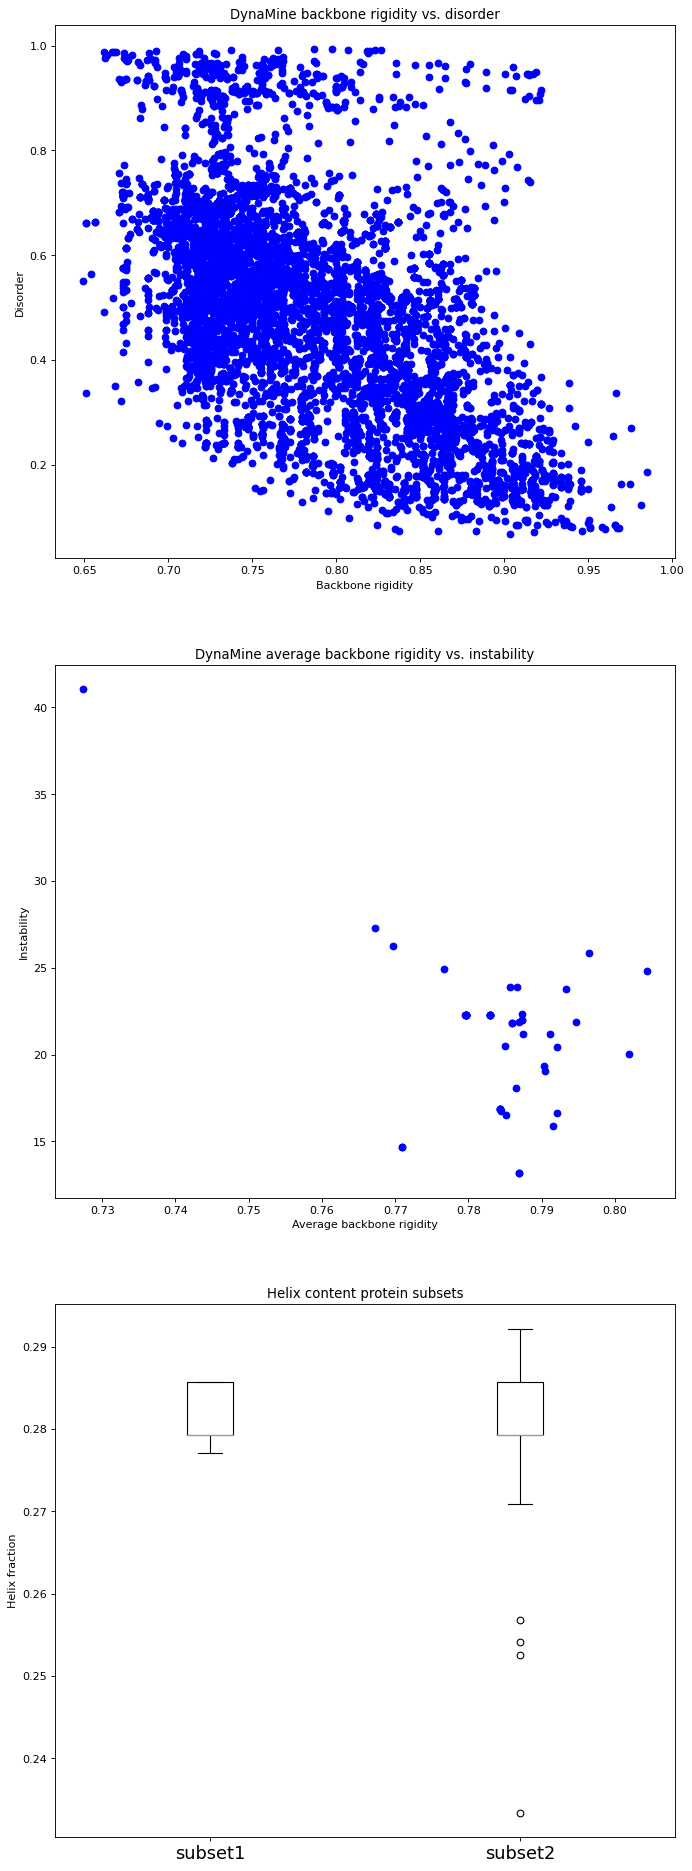

In [4]:
import scipy.stats as stats
import numpy
import matplotlib.pyplot as plt

# 
# Make a large plot to put subplots into
# 

fig = plt.figure(figsize=(10, 30), dpi= 80, facecolor='w', edgecolor='k')

#
# 1. Check the per-residue dynamine backbone values against the per-residue disomine (disorder) propensity values
#

# Here we make a single list of all residues in all proteins out of the
# list of values per protein that is now available from the pandas dataframe we made
allDynaMineValues = sum(proteinData['backbone'].values.tolist(),[]) 
allDisorderValues = sum(proteinData['disoMine'].values.tolist(),[])

# Add a subplot to the main plot - see matplotlib documentation online for more examples/info
# should you want to customise this
axes = fig.add_subplot(311)
# Make a scatter plot
axes.scatter(allDynaMineValues, allDisorderValues, color="b") 
axes.set_title("DynaMine backbone rigidity vs. disorder")
axes.set_xlabel("Backbone rigidity")
axes.set_ylabel("Disorder")

#
# You can see that higher disorder corresponds to lower backbone rigidity (more flexibility)
# It's also possible to calculate the correlation and p-value on this with the numpy package
# From that value you can see that we can be sure of this correlation (low p-value) while
# there is a negative correlation (higher rigidity, lower disorder!)
#

print("DynaMine vs. Disorder", stats.pearsonr(allDynaMineValues,allDisorderValues))

#
# 2. Check the average dynamine backbone flexibility of the protein against the
#    biopython instability
#

# Here we take the mean over all residues for the protein, and make a list of all those mean values
perProteinMeanDynaMineValues = [numpy.mean(backboneValuesPerProtein) for backboneValuesPerProtein in proteinData['backbone'].values.tolist()]
perProteinStabilityValues = proteinData['instability'].values.tolist()

print(perProteinMeanDynaMineValues)

axes = fig.add_subplot(312)
axes.scatter(perProteinMeanDynaMineValues, perProteinStabilityValues, color="b")
axes.set_title("DynaMine average backbone rigidity vs. instability")
axes.set_xlabel("Average backbone rigidity")
axes.set_ylabel("Instability")

#
# In my case, there is also a negative correlation, but it's not significant (high p value). You might have
# a better correlation for your proteins.
#

print("DynaMine vs. instability", stats.pearsonr(perProteinMeanDynaMineValues,perProteinStabilityValues))


#
# 3. Check the distribution of the helix content for two subsets of proteins
#    These subsets might come from clustering of the distances between sequences, for example, or from
#    another subset (e.g. isoelectric point)
#

# These subsets of protein ID lists you have to generate yourself based on clustering, via SPSS or via a label such as organism
proteinID_subset1 = uniprotKeys[:5]
proteinID_subset2 = uniprotKeys[5:]


# Here we get the value per protein (uniprot) ID in each subset, so the values in
# helix_subset1 correspond to the helix fractions in the proteinID_subset1 list,
# the helix_subset2 values to the ones in proteinID_subset2
helix_subset1 = [proteinData.loc[proteinID]['helixFraction'] for proteinID in proteinID_subset1]
helix_subset2 = [proteinData.loc[proteinID]['helixFraction'] for proteinID in proteinID_subset2]

# We now make a list of these separate lists in order to plot it in matplotlib
distributionData = [helix_subset1,helix_subset2]

axes = fig.add_subplot(313)
# This adds a boxplot
axes.boxplot(distributionData)
axes.set_title("Helix content protein subsets")
axes.set_ylabel("Helix fraction")
# Here we label the boxplots on the x-axis
axes.set_xticklabels(['subset1','subset2'],fontsize=16)

#
# We can also compare their distributions with many tests, here using a Mann-Whitney non-parametric test
#

print(stats.mannwhitneyu(helix_subset1,helix_subset2))


## 5. Exporting data for SPSS

We can use the same data preparation, but then output files for SPSS to work with the statistical test in there. Here a couple of examples

If you run into problems with 'ModuleNotFoundError' for 'pyreadstat', you have to open your conda terminal (on Windows) or open a terminal window (on Mac/Linux), and type:
```conda install -c conda-forge pyreadstat```


In [5]:
import pyreadstat

# First we make a copy of the pandas dataframe, as we need to modify it
# in order to get all the data across to SPSS
proteinDataCopy = proteinData.copy()

# SPSS does not accept all characters in column names, so doing some renaming here
# Should you get an 'ReadstatError: A provided name contains an illegal character' error,
# check if you added any Uniprot fields that have spaces or 'weird' characters in them
# and remap them here.
proteinDataCopy.rename(columns={"Entry name": "uniprotID",
                            "Gene names": "geneNames",
                            "3D": "StructureAvailable",
                            "Post-translational modification": "PTM",
                            "Cross-reference (EMBL)": "EMBL",
                            "Cross-reference (GenBank)": "GenBank",
                            "Cross-reference (GeneID)": "GeneID",
                            "Taxonomic lineage": "TaxonomicLineage",
                            "Taxonomic lineage (all)": "TaxonomicLineageAll",
                            "Function [CC]": "functionCC",
                            "Interacts with": "interactsWith",
                            "Domain [CC]": "domainCC",
                            "Protein families": "proteinFamilies"
                           },inplace=True)

# Instead of giving SPSS the list of the predicted values for all residues per protein,
# we are here calculating the mean value for that list, so that we end up with a single
# value for each protein. This can then be used for, for example, PCA or cluster analysis
# In addition, for the amino acids a separate column has to be made, as SPSS cannot deal
# with the Python dictionaries
for dataName in proteinDataCopy.columns:
    dataValuesList = proteinDataCopy[dataName]
    # Check whether this is a list of values
    if type(dataValuesList[0]) == type([]):
        # If this is a list, then take the mean value and replace the original values
        dataValuesList = [numpy.mean(dataList) for dataList in dataValuesList[:]]
        proteinDataCopy[dataName] = dataValuesList
        print(dataName,dataValuesList[0])
    elif type(dataValuesList[0]) == type({}):
        # If this is a dictionary, make new columns per dictionary entry with the values
        for aaKey in dataValuesList[0]:
            dataLabel = "{}_{}".format(dataName,aaKey)
            proteinDataCopy[dataLabel] = [dataList[aaKey] for dataList in dataValuesList]
            print(dataLabel, proteinDataCopy[dataLabel][0])
        # Removing the original column, no use for SPSS
        del(proteinDataCopy[dataName])
    else:  
        print(dataName,dataValuesList[0])

# Names of all the data columns
print(proteinDataCopy.columns)

# Dump all data
pyreadstat.write_sav(proteinDataCopy, 'proteinData.sav')

# Dump only specific columns of the data
pyreadstat.write_sav(proteinDataCopy[['helixFraction','sheetFraction','coilFraction']], 'proteinDataSubset.sav')


# Here we also reorganise the distance data for SPSS, and save it, so that you can do a clustering 
# analysis in SPSS using directly this distance data. Note that you can also do a clustering based
# on other characteristics from the proteinData.sav file!
distanceMatrix = pd.DataFrame.from_dict(sequenceDistances)
pyreadstat.write_sav(distanceMatrix, 'distanceMatrix.sav')



uniprotID A0A024R1G3_HUMAN
geneNames MB hCG_41530
Organism Homo sapiens (Human)
PTM nan
StructureAvailable nan
EMBL CH471095;CH471095;
GenBank nan
GeneID nan
TaxonomicLineageAll cellular organisms, Eukaryota, Opisthokonta, Metazoa, Eumetazoa, Bilateria, Deuterostomia, Chordata, Craniata, Vertebrata, Gnathostomata (jawed vertebrates), Teleostomi, Euteleostomi, Sarcopterygii, Dipnotetrapodomorpha, Tetrapoda, Amniota, Mammalia, Theria, Eutheria, Boreoeutheria, Euarchontoglires, Primates, Haplorrhini, Simiiformes, Catarrhini, Hominoidea (apes), Hominidae (great apes), Homininae, Homo, Homo sapiens (Human)
disoMine 0.40115351153604956
backbone 0.8018704819277108
sidechain 0.49765391566265055
earlyFolding 0.10115012261899677
aminoAcidNumbers_A 13
aminoAcidNumbers_C 4
aminoAcidNumbers_D 8
aminoAcidNumbers_E 15
aminoAcidNumbers_F 7
aminoAcidNumbers_G 16
aminoAcidNumbers_H 9
aminoAcidNumbers_I 8
aminoAcidNumbers_K 21
aminoAcidNumbers_L 18
aminoAcidNumbers_M 5
aminoAcidNumbers_N 3
aminoAcidNumbe